In [81]:
import csv
import sys
import glob, os
import copy
import gc
from tqdm import tqdm
import time
import math
from PIL import Image
import cv2
from shapely.geometry import MultiPolygon, Polygon, Point
import shapely.wkt
import shapely.affinity
import rasterio as rio
from rasterio.enums import Resampling
from rasterio.plot import show
import rasterio.mask
import gdal
import ogr
import numpy as np
import random
import pandas as pd
import tifffile as tiff
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import itertools
import psutil
sys.setrecursionlimit(10**6)
from skimage import morphology
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader, TensorDataset
from torch.utils.data.dataset import Subset
from torchsummary import summary
#import segmentation_models_pytorch as smp
#from segmentation_models_pytorch.encoders import get_preprocessing_fn
import pytorch_lightning as pl
from pytorch_lightning import Trainer
from pytorch_lightning import LightningModule
from pytorch_lightning.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
import albumentations as album

In [82]:
print(torch.cuda.is_available())
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

True


In [83]:
#  get data list
path_3band = '../building_detection_data/3band_train/3band/'
path_8band = '../building_detection_data/8band_train/8band/'
path_3band_test = '../building_detection_data/3band_test/'
path_8band_test = '../building_detection_data/8band_test/'
path_geojson = '../building_detection_data/geojson_train/'
path_mask_img = '../building_detection_data/MaskImages/'

def get_list(path):
    return [f for f in os.listdir(path) if not f.startswith('.')]

list_3band = get_list(path_3band)
list_8band = get_list(path_8band)
list_geojson = get_list(path_geojson)

list_3band_test = get_list(path_3band_test)
list_8band_test = get_list(path_8band_test)

open sat imgs trial

(448, 448, 3)


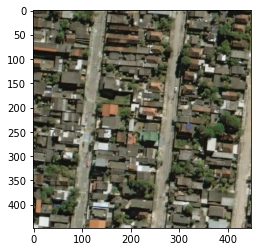

In [4]:
img = rio.open('../building_detection_data/3band_train/3band/3band_AOI_1_RIO_img3745.tif')
data = img.read(out_shape=(448, 448), resampling=Resampling.bilinear)

data = data.transpose(1,2,0)
if data.max()!= 0:
    data = data / data.max()
print(data.shape)
img = np.array(data)
plt.imshow(img)

In [5]:
img.transpose(2,0,1).shape

(3, 448, 448)

(448, 448) <class 'numpy.ndarray'>


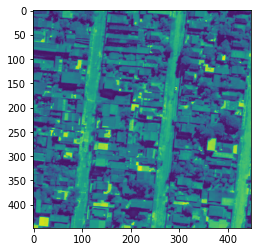

In [6]:
from skimage.color import rgb2gray
img_gray = rgb2gray(img)
print(img_gray.shape, type(img_gray))
if img_gray.max() != 0:
    img_gray = img_gray / img_gray.max()
plt.imshow(img_gray)

In [7]:
img_gray.max()

1.0

In [8]:
img = rio.open('../building_detection_data/3band_train/3band/3band_AOI_1_RIO_img3745.tif')
data = img.read(out_shape=(224, 224), resampling=Resampling.bilinear)
data = data.transpose(1,2,0)
img = np.array(data)
img[:,:,0].max()

242

(224, 224, 3)


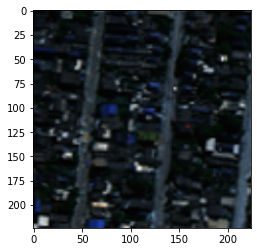

In [9]:
img = rio.open('../building_detection_data/8band_train/8band/8band_AOI_1_RIO_img3745.tif')
data = img.read(out_shape=(224, 224), resampling=Resampling.bilinear)
data = data.transpose(1,2,0)
data = np.stack([data[:,:,1], data[:,:,2], data[:,:,4]], axis=2)
if data.max()!= 0:
    data = data / data.max()
print(data.shape)
img = np.array(data)
plt.imshow(img)

In [10]:
img = rio.open('../building_detection_data/8band_train/8band/8band_AOI_1_RIO_img3745.tif')
data = img.read(out_shape=(224, 224), resampling=Resampling.bilinear)
data = data.transpose(1,2,0)
img = np.array(data)
img[:,:,6].max()

6265

In [11]:
import os
print(len(os.listdir("../building_detection_data/3band_train/3band")))
print(len(os.listdir("../building_detection_data/8band_train/8band")))
print(len(os.listdir("../building_detection_data/MaskImages")))
print(len(os.listdir("../building_detection_data/3band_test")))
print(len(os.listdir("../building_detection_data/8band_test")))

6940
6940
6940
2795
2795


(406, 439, 1)


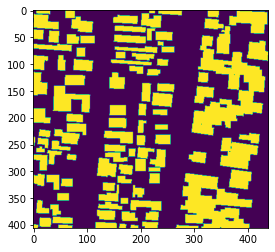

In [12]:
mask = rio.open('../building_detection_data/MaskImages/AOI_1_RIO_img3745.tif')
data = mask.read()
data = data.transpose(1,2,0)
print(data.shape)
mask = np.array(data)
plt.imshow(mask)

create mask images

In [13]:
def create_poly_mask(rasterSrc, vectorSrc, npDistFileName=''):

    # load vector
    source_ds = ogr.Open(vectorSrc)
    source_layer = source_ds.GetLayer()

	# load raster
    srcRas_ds = gdal.Open(rasterSrc)
    cols = srcRas_ds.RasterXSize
    rows = srcRas_ds.RasterYSize
        
    dstPath = npDistFileName

	# create mask img
    memdrv = gdal.GetDriverByName('GTiff') 
    dst_ds = memdrv.Create(dstPath, cols, rows, 1, gdal.GDT_Byte)
    dst_ds.SetGeoTransform(srcRas_ds.GetGeoTransform())
    dst_ds.SetProjection(srcRas_ds.GetProjection())
    band = dst_ds.GetRasterBand(1)
    band.SetNoDataValue(0)
    gdal.RasterizeLayer(dst_ds, [1], source_layer, burn_values=[255], options=['COMPRESS=LZW'])
    dst_ds = 0
    
    mask_image = Image.open(dstPath)
    mask_image = np.array(mask_image)
    
    return mask_image


def build_labels(src_raster_dir, src_vector_dir, dst_dir):
	
    os.makedirs(dst_dir, exist_ok=True)

    file_count = len([f for f in os.walk(src_vector_dir).__next__()[2] if f[-8:] == ".geojson"])

    print("[INFO] Found {} geojson files. Preparing building mask images...".format(file_count))

    for idx in tqdm(range(1, file_count + 1)):

        src_raster_filename = "3band_AOI_1_RIO_img{}.tif".format(idx)
        src_vector_filename = "Geo_AOI_1_RIO_img{}.geojson".format(idx)
        dst_filename = "AOI_1_RIO_img{}.tif".format(idx)

        src_raster_path = os.path.join(src_raster_dir, src_raster_filename)
        src_vector_path = os.path.join(src_vector_dir, src_vector_filename)
        dst_path = os.path.join(dst_dir, dst_filename)

        create_poly_mask(
            src_raster_path, src_vector_path, npDistFileName=dst_path
        )

In [14]:
#build_labels(path_3band, path_geojson, path_mask_img)

In [84]:
list_masks = get_list(path_mask_img)

list_3band = sorted(list_3band)
list_8band = sorted(list_8band)
list_3band_test = sorted(list_3band_test)
list_8band_test = sorted(list_8band_test)
list_masks = sorted(list_masks)

In [16]:
#  resize images
s = 224
N = len(list_3band)

def standardize(img):
    mean = img.mean()
    std = img.std()
    if(std != 0):
        img = (img - mean) / std
    return img    

def resize_images(list, path):
    images = []
    for i in tqdm(list):
        im = rio.open(path + i)
        im = im.read(out_shape=(s,s), resampling=Resampling.bilinear)
        if im.max()!=0:
            im = im / im.max()
        #im = standardize(im)
        images.append(im)
    return images

# # added by yoshioka 2021/06/05
# def resize_images_8band_to_4band(list, path):
#     images = []
#     for i in tqdm(list):
#         im = rio.open(path+i)
#         im = im.read(out_shape=(s,s), resampling=Resampling.bilinear)
#         if im.max()!=0:
#             im = im / im.max()
#         im = np.stack([im[1,:,:], im[2,:,:], im[4,:,:], im[6,:,:]], axis=0)
#         images.append(im)
#     return images

# added by yoshioka 2021/06/05
def resize_images_make_4band(list_3band, list_8band, three_band_path, eight_band_path):
    images = []
    for i, j in tqdm(zip(list_3band, list_8band)):
        im_3band = rio.open(three_band_path+i)
        im_8band = rio.open(eight_band_path+j)
        im_3band = im_3band.read(out_shape=(s,s), resampling=Resampling.bilinear)
        im_8band = im_8band.read(out_shape=(s,s), resampling=Resampling.bilinear)
        
        im_3band = np.array(im_3band)
        im_3band = im_3band / im_3band.max()
        
        im_8band = np.array(im_8band)
        im_8band = im_8band / im_8band.max()
        
        im_cat = np.stack([im_3band[0,:,:], im_3band[1,:,:], im_3band[2,:,:], im_8band[6,:,:]], axis=0)
        # --------------warning-----------------
        # The following normalization causes the images to be very dark!!
        if im_cat.max()!=0:
            im_cat = im_cat / im_cat.max()

        # im_cat = standardize(im_cat) # -> it causes wrong result
        images.append(im_cat)
    return images

# revised by yoshioka 2021/06/05
# to change the 3 band images to 4 band images
# by adding NIR in 8 band images
def get_batch_imgs(b, lists=[list_3band, list_8band], paths=[path_3band, path_8band]):
    out = np.zeros((N, b, s, s))
    if b == 8:
        for i, img in tqdm(enumerate(resize_images(lists[1], paths[1]))):
            out[i,:,:,:] = img
    elif b == 3:
        for i, img in tqdm(enumerate(resize_images(lists[0], paths[0]))):
            out[i,:,:,:] = img
    elif b == 4:
        for i, img in tqdm(enumerate(resize_images_make_4band(lists[0], lists[1], paths[0], paths[1]))):
            out[i,:,:,:] = img
    else:
        print("ERROR IN BAND NUMBER!")
    return out

def get_batch_masks(list, path):
    out = np.zeros((N, s, s))
    for i, img in tqdm(enumerate(resize_images(list, path))):
        out[i,:,:] = img
    return out

# def concat_band(list3, list8):
#     out = np.zeros((N, 11, s, s))
#     for i, (j, k) in tqdm(enumerate(zip(list3, list8))):
#         im = np.concatenate([j,k],0)
#         out[i,:,:,:] = im
#     return out

dataset / dataloader

In [85]:
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np
from torch.nn import functional as F
from torchvision import transforms
import albumentations as album
import random
import cv2
from skimage.color import rgb2gray

def preprocess(x, y):
    #x = x / MAX
    x = torch.from_numpy(x.astype('float32'))#.permute(1,2,0)
    if y is not None:
        y = torch.from_numpy(y.astype('float32'))#.permute(1,2,0)
        #y = F.one_hot(y, num_classes=2).permute(2,0,1)
    return x, y
    
def get_augmentation():
    border = cv2.BORDER_CONSTANT
    transform = [
        #album.Blur(),
        #album.OpticalDistortion(distort_limit=2, border_mode=border),
        #album.ElasticTransform(alpha=50, border_mode=border),
        #album.Rotate(limit=15, border_mode=border),
        album.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.1, rotate_limit=0.5, border_mode=border),
        #album.ShiftScaleRotate(shift_limit=0, scale_limit=0.2, rotate_limit=0, border_mode=border),
        album.imgaug.transforms.IAAAffine(shear=10, mode='constant'),
        album.HorizontalFlip(p=0.5),
        album.VerticalFlip(p=0.5), # 反転する代わりに色が変化している？
        #album.RGBShift(r_shift_limit=10, g_shift_limit=10, b_shift_limit=20, always_apply=False, p=0.5),
    ]
    return album.Compose(transform, p=1.0)

def get_loader(dataset, batch_size, shuffle=False):
    return DataLoader(dataset, batch_size, shuffle)

class SatelliteDatasetForGrayscale(Dataset):
    def __init__(self, img_3band_dir, mask_dir, augmentations, img_3band_ids, mask_ids, shape):
        super().__init__()
        self.img_3band_dir = img_3band_dir
        self.mask_dir = mask_dir
        self.augmentations = augmentations
        self.img_3band_ids = img_3band_ids
        self.mask_ids = mask_ids
        self.shape = shape
        assert len(img_3band_ids) == len(mask_ids), 'lengths of 3band and masks datasets are not equal'
        self.data_size = len(img_3band_ids)
        
    def __len__(self):
        return self.data_size
        
    def __getitem__(self, index):
        img_3band_id, mask_id = self.img_3band_ids[index], self.mask_ids[index]
        
        img_3band = rio.open(self.img_3band_dir + '/' + img_3band_id)
        mask = rio.open(self.mask_dir + '/' + mask_id)
        
        img_3band = img_3band.read(out_shape=(self.shape, self.shape), resampling=Resampling.bilinear).astype('float32')
        mask = mask.read(out_shape=(self.shape, self.shape), resampling=Resampling.bilinear).astype('float32')
        
        img_3band = np.array(img_3band)
        if img_3band.max() != 0:
            img_3band = img_3band / img_3band.max()
        
        img_3band = img_3band.transpose(1,2,0) # change to ch-last(HxWxch)
        img_gray = rgb2gray(img_3band) # HxW(there is no ch)
        img_gray = img_gray[:,:,np.newaxis] # change to HxWxch

        if img_gray.max() != 0:
            img_gray = img_gray / img_gray.max()
        
        if mask.max() != 0:
            mask = mask / mask.max()
            
        mask = mask.transpose(1,2,0) # change to ch-last
        
        if self.augmentations is not None:
            aug = self.augmentations(image=img_gray, mask=mask)
            img_gray, mask = aug['image'], aug['mask']
            img_gray, mask = preprocess(img_gray, mask)
            img_gray = img_gray.permute(2,0,1) # change to ch-first
            mask = mask.permute(2,0,1) # change to ch-first
        else:
            img_gray, mask = preprocess(img_gray, mask)
            img_gray = img_gray.permute(2,0,1) # change to ch-first
            mask = mask.permute(2,0,1) # change to ch-first
        return img_gray, mask

In [18]:
building_satimg_dataset = SatelliteDatasetForGrayscale(img_3band_dir=path_3band, mask_dir=path_mask_img, augmentations=None, img_3band_ids=list_3band, mask_ids=list_masks, shape=224)
print(building_satimg_dataset.__len__())

6940


In [19]:
img, mask = building_satimg_dataset.__getitem__(1200)
img.shape, mask.shape

(torch.Size([1, 224, 224]), torch.Size([1, 224, 224]))

(224, 224, 1)


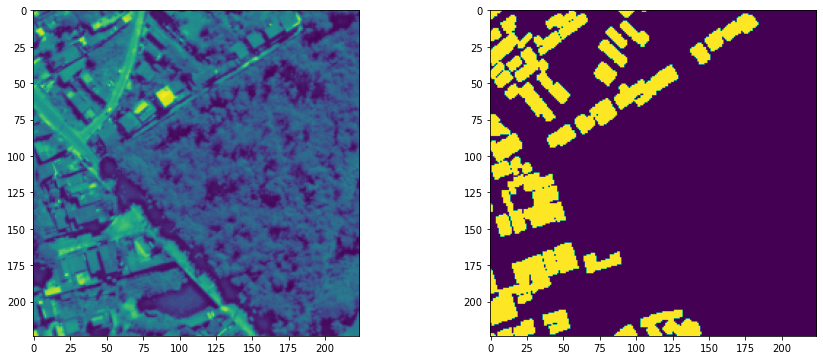

In [20]:
img = img.detach().numpy().transpose(1,2,0)
mask = mask.detach().numpy().squeeze()

print(img.shape)
fig, axes = plt.subplots(1,2,figsize=(15,6))
axes[0].imshow(img)
axes[1].imshow(mask)

/opt/conda/lib/python3.7/site-packages/albumentations/imgaug/transforms.py:337: FutureWarning: This IAAAffine is deprecated. Please use Affine instead
  warnings.warn("This IAAAffine is deprecated. Please use Affine instead", FutureWarning)


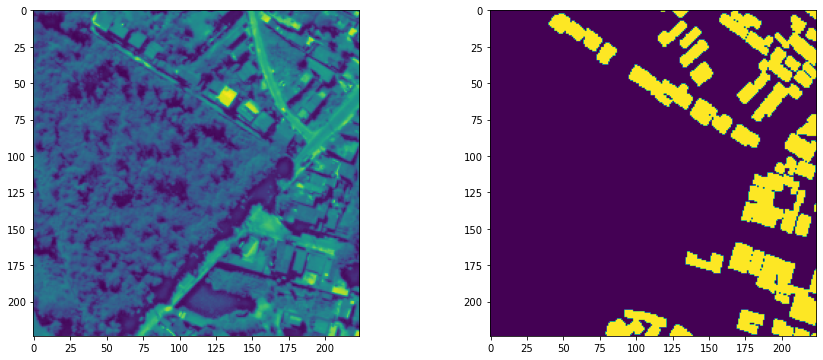

In [21]:
building_satimg_dataset_augmentated = SatelliteDatasetForGrayscale(img_3band_dir=path_3band, mask_dir=path_mask_img, augmentations=get_augmentation(), img_3band_ids=list_3band, mask_ids=list_masks, shape=224)

img, mask = building_satimg_dataset_augmentated.__getitem__(1200)

img = img.detach().numpy().transpose(1,2,0)
mask = mask.detach().numpy().squeeze()

fig, axes = plt.subplots(1,2,figsize=(15,6))
axes[0].imshow(img)
axes[1].imshow(mask)

concatnate dataset

In [22]:
from torch.utils.data.dataset import ConcatDataset
building_satimg_dataset_concatnated = ConcatDataset([building_satimg_dataset, building_satimg_dataset_augmentated])
print(building_satimg_dataset_concatnated.__len__())

13880


In [23]:
from torch.utils.data.dataset import Subset

n_samples = len(building_satimg_dataset_concatnated)
train_size = int(n_samples * 0.8)

train_subset_indices = list(range(0, train_size))
val_subset_indices = list(range(train_size,n_samples))

train_dataset = Subset(building_satimg_dataset_concatnated, train_subset_indices)
val_dataset = Subset(building_satimg_dataset_concatnated, val_subset_indices)

train_4b_loader = get_loader(dataset=train_dataset, batch_size=16, shuffle=True)
val_4b_loader = get_loader(dataset=val_dataset, batch_size=1, shuffle=False)

In [24]:
#  configure
criterion = nn.BCELoss()

#  Metrics
epsilon = 1e-6
def IoU(pred, mask):
    pred = pred.cpu().numpy().astype(int)
    mask = mask.cpu().numpy().astype(int)
    intersection = (pred & mask).sum()
    union = (pred | mask).sum()
    out = (intersection + epsilon) / (union + epsilon)
    return out

In [25]:
# Early stopping
# https://github.com/Bjarten/early-stopping-pytorch
class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=7, verbose=False):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement. 
                            Default: False
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf

    def __call__(self, val_loss, model):

        
        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score:
            self.counter += 1
            print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
                #self.counter = 0
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), 'checkpoint.pt')
        self.val_loss_min = val_loss

In [86]:
#  U-Net Model
#  https://github.com/usuyama/pytorch-unet/blob/master/pytorch_unet.py

theta = (0.005, 0.01, 0.015, 0.02, 0.025) # change detectionにおける閾値

def double_conv(in_channels, out_channels, stride, padding):
    return nn.Sequential(
        nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=3, stride=stride, padding=padding),
        nn.ReLU(inplace=True),
        nn.Conv2d(out_channels, out_channels, 3, padding=1),
        nn.ReLU(inplace=True)
    )

class UNet(nn.Module):
    def __init__(self, input_ch, n_class):
        super().__init__()
        
        self.dconv_down1 = double_conv(input_ch, 64, 1, 1)
        self.dconv_down2 = double_conv(64, 128, 1, 1)
        self.dconv_down3 = double_conv(128, 256, 1, 1)
        self.dconv_down4 = double_conv(256, 512, 1, 1)
        self.dconv_down5 = double_conv(512,1024, 1, 1)
        self.maxpool = nn.MaxPool2d(2)
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.dconv_up4 = double_conv(512+1024, 512, 1, 1) # stride=2,padding=0は失敗
        self.dconv_up3 = double_conv(256+512, 256, 1, 1)
        self.dconv_up2 = double_conv(128+256, 128, 1, 1)
        self.dconv_up1 = double_conv(64+128, 64, 1, 1)
        self.conv_last = nn.Conv2d(64, n_class, 1)
        #self.mode = mode # 1: 1枚の画像に対して学習/推論, 2: 2枚の画像を用いてDIを作成
        
    def forward(self, *x):
        if len(x) == 1:
            x = x[0]
            conv1 = self.dconv_down1(x)
            x = self.maxpool(conv1)
            conv2 = self.dconv_down2(x)
            x = self.maxpool(conv2)
            conv3 = self.dconv_down3(x)
            x = self.maxpool(conv3)
            conv4 = self.dconv_down4(x)
            x = self.maxpool(conv4)
            conv5 = self.dconv_down5(x)
            x = self.upsample(conv5)
            x = torch.cat([x, conv4], dim=1)
            x = self.dconv_up4(x)
            x = self.upsample(x)
            x = torch.cat([x, conv3], dim=1)
            x = self.dconv_up3(x)
            x = self.upsample(x)
            x = torch.cat([x, conv2], dim=1)
            x = self.dconv_up2(x)
            x = self.upsample(x)
            x = torch.cat([x, conv1], dim=1)
            x = self.dconv_up1(x)
            out = self.conv_last(x)
            return out
        elif len(x) == 2:
            # encode
            # conv for each image
            conv_1 = self.dconv_down1(x[0].to(device))
            conv_2 = self.dconv_down1(x[1].to(device))
            # threshold processing
            di1 = abs(conv_1 - conv_2)
            di1 = torch.where(di1 <= theta[0], torch.tensor(0.).to(device), conv_2.to(device))
            # pooling
            x_1 = self.maxpool(conv_1)
            x_2 = self.maxpool(conv_2)
            # conv for each image
            conv_1 = self.dconv_down2(x_1)
            conv_2 = self.dconv_down2(x_2)
            # threshold processing
            di2 = abs(conv_1 - conv_2)
            di2 = torch.where(di2 <= theta[1], torch.tensor(0.).to(device), conv_2.to(device))
            # pooling
            x_1 = self.maxpool(conv_1)
            x_2 = self.maxpool(conv_2)
            # conv for each image
            conv_1 = self.dconv_down3(x_1)
            conv_2 = self.dconv_down3(x_2)
            # threshold processing
            di3 = abs(conv_1 - conv_2)
            di3 = torch.where(di3 <= theta[2], torch.tensor(0.).to(device), conv_2.to(device))
            # pooling
            x_1 = self.maxpool(conv_1)
            x_2 = self.maxpool(conv_2)
            # conv for each image
            conv_1 = self.dconv_down4(x_1)
            conv_2 = self.dconv_down4(x_2)
            # threshold processing
            di4 = abs(conv_1 - conv_2)
            di4 = torch.where(di4 <= theta[3], torch.tensor(0.).to(device), conv_2.to(device))
            # pooling
            x_1 = self.maxpool(conv_1)
            x_2 = self.maxpool(conv_2)
            # conv for each image
            conv_1 = self.dconv_down5(x_1)
            conv_2 = self.dconv_down5(x_2)
            # threshold processing
            di5 = abs(conv_1 - conv_2)
            di5 = torch.where(di5 <= theta[4], torch.tensor(0.).to(device), conv_2.to(device))
            
            # convolutionのみパラメータを有する
            # convolution層は全て名称が存在（区別可能） -> 学習したパラメータはメソッド（dconv_down1とか）とセットで保存されているはず
            # len=2でネットワーク構造が変化しても, 当該メソッドは利用可能と判断される
            
            # decode
            x = self.upsample(di5)
            x = torch.cat([x, di4], dim=1)
            x = self.dconv_up4(x)
            x = self.upsample(x)
            x = torch.cat([x, di3], dim=1)
            x = self.dconv_up3(x)
            x = self.upsample(x)
            x = torch.cat([x, di2], dim=1)
            x = self.dconv_up2(x)
            x = self.upsample(x)
            x = torch.cat([x, di1], dim=1)
            x = self.dconv_up1(x)
            out = self.conv_last(x)
            return out
            
model = UNet(1, 1)
model = model.to(device)  

from torchsummary import summary
summary(model, (1, 224, 224))    

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]             640
              ReLU-2         [-1, 64, 224, 224]               0
            Conv2d-3         [-1, 64, 224, 224]          36,928
              ReLU-4         [-1, 64, 224, 224]               0
         MaxPool2d-5         [-1, 64, 112, 112]               0
            Conv2d-6        [-1, 128, 112, 112]          73,856
              ReLU-7        [-1, 128, 112, 112]               0
            Conv2d-8        [-1, 128, 112, 112]         147,584
              ReLU-9        [-1, 128, 112, 112]               0
        MaxPool2d-10          [-1, 128, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]         295,168
             ReLU-12          [-1, 256, 56, 56]               0
           Conv2d-13          [-1, 256, 56, 56]         590,080
             ReLU-14          [-1, 256,

In [27]:
def func(*arg):
    return arg

x = func([1,2,3], [2,3,4])
print(len(x))

2


In [28]:
x = torch.randn(3,2)
y = torch.ones(3,2)
print(x)
print(y)
print(x-y)
print(abs(x-y))

tensor([[ 1.4058,  1.3019],
        [-0.2988, -1.2403],
        [ 1.4403, -1.5601]])
tensor([[1., 1.],
        [1., 1.],
        [1., 1.]])
tensor([[ 0.4058,  0.3019],
        [-1.2988, -2.2403],
        [ 0.4403, -2.5601]])
tensor([[0.4058, 0.3019],
        [1.2988, 2.2403],
        [0.4403, 2.5601]])


training

In [87]:
#  train 
def train(model, optimizer, train_loader, val_loader, epochs):
    model.train()
    log = {"train_loss":[], "train_iou":[], "val_loss":[], "val_iou":[]}
    early_stopping = EarlyStopping(5, True)
    for epoch in tqdm(range(epochs)):
        epoch_loss = 0
        epoch_iou = 0
        for data, mask in train_loader:
            data, mask = data.to(device), mask.to(device)
            mask = mask.view(-1)
            out = model(data)
            out = torch.sigmoid(out)
            out = out.view(-1)
            loss = criterion(out, mask)
            pred = torch.where(out >= 0.5, torch.tensor(1.).to(device), torch.tensor(0.).to(device))
            iou = IoU(pred, mask)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            epoch_loss += float(loss.item())
            epoch_iou += float(iou.item())
        epoch_loss = epoch_loss / len(train_loader)
        epoch_iou = epoch_iou / len(train_loader)
        log["train_loss"].append(epoch_loss)
        log["train_iou"].append(epoch_iou)
        
        # validation
        val_loss = 0
        val_iou = 0
        with torch.no_grad():
            for data, mask in val_loader:
                data, mask = data.to(device), mask.to(device)
                mask = mask.view(-1)
                out = model(data)
                out = torch.sigmoid(out)
                out = out.view(-1)
                loss = criterion(out, mask)
                pred = torch.where(out >= 0.5, torch.tensor(1.).to(device), torch.tensor(0.).to(device))
                iou = IoU(pred, mask)
                val_loss += float(loss.item())
                val_iou += float(iou.item())
        val_loss = val_loss / len(val_loader)
        val_iou = val_iou / len(val_loader)
        log["val_loss"].append(val_loss)
        log["val_iou"].append(val_iou)
        print('epoch{}:終了  train_loss={}, train_iou={}, val_loss={}, val_iou={}\n'.format(epoch, epoch_loss, epoch_iou, val_loss, val_iou))
        early_stopping(val_loss, model)
        if early_stopping.early_stop:
            print("Early stopping")
            break
        
    
    fig = plt.figure(figsize=(12,6))
    plt.subplot(1,2,1)
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.plot(log["train_loss"], color='orangered', label='train')
    plt.plot(log["val_loss"], color='cyan', label='val')
    plt.legend(loc=0)
    
    plt.subplot(1,2,2)
    plt.xlabel('epoch')
    plt.ylabel('iou')
    plt.plot(log["train_iou"], color='orangered', label='train')
    plt.plot(log["val_iou"], color='cyan', label='val')
    plt.legend(loc=0)
    plt.show()
    fig.savefig("img/train_log.png")
    return log
    
        
#  test
threshold = 0.5
def test(model, load_test):
    model.load_state_dict(torch.load('checkpoint.pt'))
    model.eval()
    test_loss = 0
    test_iou = 0
    for data, mask in tqdm(load_test):
        data, mask = data.to(device), mask.to(device)
        mask = mask.view(-1)
        out = model(data)
        out = torch.sigmoid(out)
        out = out.view(-1)
        loss = criterion(out, mask)
        test_loss += float(loss.item())
        pred = torch.where(out >= 0.5, torch.tensor(1.).to(device), torch.tensor(0.).to(device))
        #pred_np = pred.to('cpu').detach().numpy().copy().reshape(224,224)
        #pred = morphology.binary_closing(pred_np, morphology.diamond(1)).astype(np.uint8)
        #pred = torch.from_numpy(pred).view(-1).to(device)
        iou = IoU(pred, mask)
        test_iou += float(iou.item())
    test_loss = test_loss/len(load_test)
    test_iou = test_iou/len(load_test)
    print('テスト終了  test_loss={},  test_iou={}'.format(test_loss, test_iou))

  0%|          | 0/30 [00:00<?, ?it/s]

epoch0:終了  train_loss=0.29437668269408884, train_iou=0.05427056001166015, val_loss=0.22129872113760488, val_iou=0.29351813245561603

Validation loss decreased (inf --> 0.221299).  Saving model ...


  3%|▎         | 1/30 [10:32<5:05:56, 632.98s/it]

epoch1:終了  train_loss=0.21886194334164133, train_iou=0.28605714722858644, val_loss=0.17142164791022263, val_iou=0.42757814894283386

Validation loss decreased (0.221299 --> 0.171422).  Saving model ...


 10%|█         | 3/30 [31:39<4:44:53, 633.09s/it]

epoch2:終了  train_loss=0.19244549763241317, train_iou=0.3800618326208309, val_loss=0.1904893100603375, val_iou=0.38292393944917114

EarlyStopping counter: 1 out of 5
epoch3:終了  train_loss=0.17732462067940738, train_iou=0.4354780048020695, val_loss=0.14892522543728184, val_iou=0.499161704107165

Validation loss decreased (0.171422 --> 0.148925).  Saving model ...


 13%|█▎        | 4/30 [42:13<4:34:27, 633.37s/it]

epoch4:終了  train_loss=0.16374661946288102, train_iou=0.4791011520585889, val_loss=0.13544333161512087, val_iou=0.5489515221335006

Validation loss decreased (0.148925 --> 0.135443).  Saving model ...


 17%|█▋        | 5/30 [52:47<4:24:00, 633.60s/it]

epoch5:終了  train_loss=0.1546227016649947, train_iou=0.5044242663596131, val_loss=0.12383949236607734, val_iou=0.5853036574004346

Validation loss decreased (0.135443 --> 0.123839).  Saving model ...


 20%|██        | 6/30 [1:03:21<4:13:33, 633.91s/it]

epoch6:終了  train_loss=0.15078259578312853, train_iou=0.5146729032643855, val_loss=0.11837969878055353, val_iou=0.6098050750930213

Validation loss decreased (0.123839 --> 0.118380).  Saving model ...


 27%|██▋       | 8/30 [1:24:31<3:52:37, 634.43s/it]

epoch7:終了  train_loss=0.14394782826046779, train_iou=0.5368585027142023, val_loss=0.12096019952653109, val_iou=0.575229171653989

EarlyStopping counter: 1 out of 5


 30%|███       | 9/30 [1:35:03<3:41:49, 633.77s/it]

epoch8:終了  train_loss=0.14176238102768615, train_iou=0.5430346165199891, val_loss=0.1313374083136778, val_iou=0.5702275386852592

EarlyStopping counter: 2 out of 5
epoch9:終了  train_loss=0.13818529689475165, train_iou=0.5526006416423884, val_loss=0.11513941340305545, val_iou=0.6128552222892559

Validation loss decreased (0.118380 --> 0.115139).  Saving model ...


 33%|███▎      | 10/30 [1:45:37<3:31:14, 633.73s/it]

epoch10:終了  train_loss=0.1344008338087445, train_iou=0.5627361058327139, val_loss=0.10571392973200239, val_iou=0.6422090048500859

Validation loss decreased (0.115139 --> 0.105714).  Saving model ...


 40%|████      | 12/30 [2:06:45<3:10:08, 633.78s/it]

epoch11:終了  train_loss=0.13144181670637142, train_iou=0.5715579644415522, val_loss=0.10654260295736499, val_iou=0.6390243112964267

EarlyStopping counter: 1 out of 5


 43%|████▎     | 13/30 [2:17:19<2:59:35, 633.83s/it]

epoch12:終了  train_loss=0.12931738075094368, train_iou=0.5780627207242132, val_loss=0.10793741036655279, val_iou=0.6331959183873191

EarlyStopping counter: 2 out of 5
epoch13:終了  train_loss=0.1260766644857459, train_iou=0.5870474551507432, val_loss=0.10535111083612721, val_iou=0.6460558840177261

Validation loss decreased (0.105714 --> 0.105351).  Saving model ...


 47%|████▋     | 14/30 [2:27:53<2:49:01, 633.84s/it]

epoch14:終了  train_loss=0.12414320276497248, train_iou=0.591984933770283, val_loss=0.10079225398139315, val_iou=0.6635767793372548

Validation loss decreased (0.105351 --> 0.100792).  Saving model ...


 50%|█████     | 15/30 [2:38:26<2:38:23, 633.58s/it]

epoch15:終了  train_loss=0.1218414504472864, train_iou=0.5981742638544715, val_loss=0.09899915038694804, val_iou=0.6543784723440939

Validation loss decreased (0.100792 --> 0.098999).  Saving model ...


 53%|█████▎    | 16/30 [2:49:00<2:27:52, 633.73s/it]

epoch16:終了  train_loss=0.11949790159363825, train_iou=0.605284037374225, val_loss=0.09600837754394835, val_iou=0.6726891137598212

Validation loss decreased (0.098999 --> 0.096008).  Saving model ...


 60%|██████    | 18/30 [3:10:07<2:06:43, 633.62s/it]

epoch17:終了  train_loss=0.11860520939506397, train_iou=0.6115890132413659, val_loss=0.09625130282983205, val_iou=0.6799538881742789

EarlyStopping counter: 1 out of 5


 63%|██████▎   | 19/30 [3:20:41<1:56:11, 633.75s/it]

epoch18:終了  train_loss=0.1181467627188572, train_iou=0.609587430227607, val_loss=0.09785646194262422, val_iou=0.6651619169897833

EarlyStopping counter: 2 out of 5


 67%|██████▋   | 20/30 [3:31:14<1:45:35, 633.56s/it]

epoch19:終了  train_loss=0.11616479033491539, train_iou=0.6155855653693785, val_loss=0.09816849042677173, val_iou=0.6529854381259973

EarlyStopping counter: 3 out of 5


 70%|███████   | 21/30 [3:41:48<1:35:02, 633.58s/it]

epoch20:終了  train_loss=0.11490722745656967, train_iou=0.6200642076515844, val_loss=0.10732485014170207, val_iou=0.64125121899419

EarlyStopping counter: 4 out of 5
epoch21:終了  train_loss=0.11383474307666165, train_iou=0.6234683841682598, val_loss=0.09283848132171203, val_iou=0.6806239911136838

Validation loss decreased (0.096008 --> 0.092838).  Saving model ...


 73%|███████▎  | 22/30 [3:52:22<1:24:28, 633.62s/it]

epoch22:終了  train_loss=0.11074407131650005, train_iou=0.6314796831403935, val_loss=0.09107918181162408, val_iou=0.6898728959329611

Validation loss decreased (0.092838 --> 0.091079).  Saving model ...


 80%|████████  | 24/30 [4:13:29<1:03:21, 633.61s/it]

epoch23:終了  train_loss=0.11310916538927328, train_iou=0.6264501036910144, val_loss=0.10365382871580092, val_iou=0.6062907565552567

EarlyStopping counter: 1 out of 5


 83%|████████▎ | 25/30 [4:24:02<52:47, 633.51s/it]  

epoch24:終了  train_loss=0.11023438455381294, train_iou=0.6335126529531747, val_loss=0.0981867567370131, val_iou=0.672273493226923

EarlyStopping counter: 2 out of 5
epoch25:終了  train_loss=0.1098580183555246, train_iou=0.6344404931625891, val_loss=0.09097401095668863, val_iou=0.6895737246926468

Validation loss decreased (0.091079 --> 0.090974).  Saving model ...


 90%|█████████ | 27/30 [4:45:11<31:41, 633.84s/it]

epoch26:終了  train_loss=0.10681885330312448, train_iou=0.6430495430257314, val_loss=0.09458928225077319, val_iou=0.6811594844617426

EarlyStopping counter: 1 out of 5
epoch27:終了  train_loss=0.10577279958949137, train_iou=0.6464745611924504, val_loss=0.08847875945506942, val_iou=0.6981785360648713

Validation loss decreased (0.090974 --> 0.088479).  Saving model ...


 97%|█████████▋| 29/30 [5:06:19<10:34, 634.01s/it]

epoch28:終了  train_loss=0.1053842723970798, train_iou=0.6459947494550324, val_loss=0.09283593024185241, val_iou=0.6922958795611499

EarlyStopping counter: 1 out of 5


100%|██████████| 30/30 [5:16:52<00:00, 633.76s/it]

epoch29:終了  train_loss=0.1044645510152283, train_iou=0.6482438895178427, val_loss=0.09473884375599761, val_iou=0.6933702987687901

EarlyStopping counter: 2 out of 5


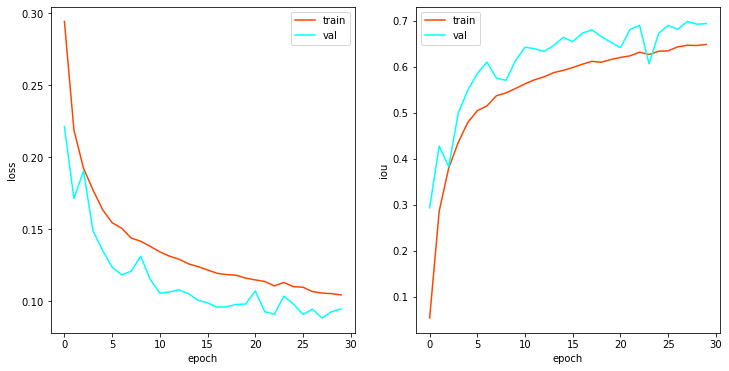

FileNotFoundError: [Errno 2] No such file or directory: 'img/train_log.png'

In [30]:
#  execute train
model = UNet(1, 1)
model = model.to(device)
optimizer = optim.Adam(model.parameters(), lr=0.0001)
log = {"train_loss":[], "train_iou":[], "val_loss":[], "val_iou":[]} 
log = train(model, optimizer, train_4b_loader, val_4b_loader, 30)

In [88]:
loaded_model = UNet(1,1)
loaded_model = loaded_model.to(device)
loaded_model.load_state_dict(torch.load('checkpoint.pt'))

summary(model, (1, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]             640
              ReLU-2         [-1, 64, 224, 224]               0
            Conv2d-3         [-1, 64, 224, 224]          36,928
              ReLU-4         [-1, 64, 224, 224]               0
         MaxPool2d-5         [-1, 64, 112, 112]               0
            Conv2d-6        [-1, 128, 112, 112]          73,856
              ReLU-7        [-1, 128, 112, 112]               0
            Conv2d-8        [-1, 128, 112, 112]         147,584
              ReLU-9        [-1, 128, 112, 112]               0
        MaxPool2d-10          [-1, 128, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]         295,168
             ReLU-12          [-1, 256, 56, 56]               0
           Conv2d-13          [-1, 256, 56, 56]         590,080
             ReLU-14          [-1, 256,

In [36]:
# one image and mask are extracted from validation dataset
data_iter = iter(val_4b_loader)
imgs, masks = data_iter.next()
img = imgs[0]
mask = masks[0]

# replace some area of img, mask with some area of img_for_crop, mask_for_crop
imgs, masks = data_iter.next()
img_for_crop = imgs[0]
mask_for_crop = masks[0]

In [37]:
img.shape, mask.shape

(torch.Size([1, 224, 224]), torch.Size([1, 224, 224]))

In [39]:
_img = img.permute(1,2,0)
img_np = _img.to("cpu").detach().numpy().copy()

_mask = mask.permute(1,2,0)
mask_np = _mask.to("cpu").detach().numpy().copy()

img_np.shape, mask_np.shape

((224, 224, 1), (224, 224, 1))

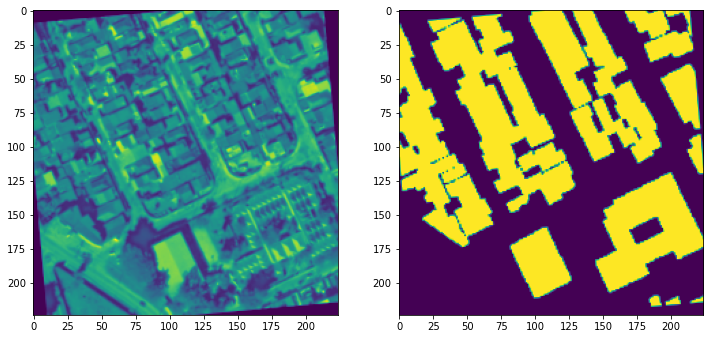

In [40]:
plt.figure(figsize=(12,12))
plt.subplot(1,2,1)
plt.imshow(img_np)
plt.subplot(1,2,2)
plt.imshow(mask_np)

In [41]:
img.shape

torch.Size([1, 224, 224])

In [44]:
img = img[np.newaxis,:,:,:]
img = img.to(device)
infer_mask = loaded_model(img)

torch.Size([224, 224])


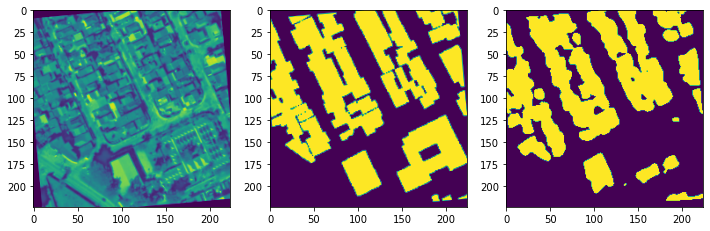

In [52]:
_infer_mask = np.squeeze(infer_mask)
print(_infer_mask.shape)
infer_mask_np = _infer_mask.to("cpu").detach().numpy().copy()
_infer_mask_np = np.where(infer_mask_np>=0.5, 1, 0)

plt.figure(figsize=(12,12))
plt.subplot(1,3,1)
plt.imshow(img_np)
plt.subplot(1,3,2)
plt.imshow(mask_np)
plt.subplot(1,3,3)
plt.imshow(_infer_mask_np)

In [ ]:
img_for_crop_np = img_for_crop.permute(1,2,0).to('cpu').detach().numpy().copy()
mask_for_crop_np = mask_for_crop.to('cpu').detach().numpy().copy()

img_for_crop_np_3band = np.stack([img_for_crop_np[:,:,0], img_for_crop_np[:,:,1], img_for_crop_np[:,:,2]], axis=2)
mask_for_crop_np_1band = np.squeeze(mask_for_crop_np)
plt.figure(figsize=(12,12))
plt.subplot(1,2,1)
plt.imshow(img_for_crop_np_3band)
plt.subplot(1,2,2)
plt.imshow(mask_for_crop_np_1band)

# Change Detection for SpaceNet dataset (building detection v1)

In [89]:
img_crop_area = img_for_crop_np_3band[50:75,50:75,:]
mask_crop_area = mask_for_crop_np_1band[50:75,50:75]

img_replaced_area = img_np_3band[50:75,50:75,:]
mask_replaced_area = mask_np_1band[50:75,50:75]

plt.figure(figsize=(12,12))
plt.subplot(2,2,1)
plt.imshow(img_replaced_area)
plt.subplot(2,2,2)
plt.imshow(mask_replaced_area)
plt.subplot(2,2,3)
plt.imshow(img_crop_area)
plt.subplot(2,2,4)
plt.imshow(mask_crop_area)

NameError: name 'img_for_crop_np_3band' is not defined

In [ ]:
_img_np_3band = img_np_3band.copy()
_mask_np_1band = mask_np_1band.copy()

_img_np_3band[50:75,50:75,:] = img_crop_area
_mask_np_1band[50:75,50:75] = mask_crop_area

In [ ]:
plt.figure(figsize=(12,12))
plt.subplot(1,2,1)
plt.imshow(_img_np_3band)
plt.subplot(1,2,2)
plt.imshow(_mask_np_1band)

In [ ]:
# 4band ver
img_crop_area_np_4band = img_for_crop_np[50:75,50:75,:]

_img_np_4band = img_np.copy()
_img_np_4band[50:75,50:75,:] = img_crop_area_np_4band

_img_np_4band.shape

In [ ]:
# confirm that some area of the 4band image is replaced
_img_np_3band_from_4band = np.stack([_img_np_4band[:,:,0], _img_np_4band[:,:,1], _img_np_4band[:,:,2]], axis=2)
plt.figure(figsize=(12,12))
plt.subplot(1,2,1)
plt.imshow(_img_np_3band_from_4band)
plt.subplot(1,2,2)
plt.imshow(_mask_np_1band)

In [ ]:
img_replaced_tensor = torch.from_numpy(_img_np_4band.astype(np.float32)).clone()
print(img_replaced_tensor.shape)
img_replaced_tensor_permute = img_replaced_tensor.permute(2,0,1)
print(img_replaced_tensor_permute.shape)

In [ ]:
#img_replaced_tensor_permute = img_replaced_tensor_permute.to(device)
print(img_replaced_tensor_permute.unsqueeze(0).shape)
pred = loaded_model(img_replaced_tensor_permute.unsqueeze(0).to(device))
pred = pred.cpu().detach().numpy().copy()
pred = np.where(pred>=0.5, 1, 0)

In [ ]:
print(pred.shape)
_pred = np.squeeze(pred)
print(_pred.shape)

In [ ]:
_pred_for_raw = loaded_model(img.unsqueeze(0).to(device))
_pred_for_raw = _pred_for_raw.cpu().detach().numpy().copy()
_pred_for_raw = np.where(_pred_for_raw>=0.5, 1, 0)
_pred_for_raw = np.squeeze(_pred_for_raw)

In [ ]:
di = np.where(abs(_pred_for_raw-_pred)>0, 1, 0)

In [ ]:
plt.figure(figsize=(12,12))
plt.subplot(1,5,1)
plt.imshow(_img_np_3band_from_4band)
plt.subplot(1,5,2)
plt.imshow(_mask_np_1band)
plt.subplot(1,5,3)
plt.imshow(_pred_for_raw)
plt.subplot(1,5,4)
plt.imshow(_pred)
plt.subplot(1,5,5)
plt.imshow(di)

In [ ]:
img = img.permute(2,0,1)
img.shape

In [ ]:
# change detection
loaded_model = loaded_model.to(device)
di_pred = loaded_model(img.unsqueeze(0), img_replaced_tensor_permute.unsqueeze(0))
di_pred = di_pred.cpu().detach().numpy().copy()
di_pred = np.where(di_pred>=0.5, 1, 0)

In [ ]:
print(di_pred.shape)
_di_pred = np.squeeze(di_pred)
print(_di_pred.shape)

In [ ]:
plt.figure(figsize=(12,12))
plt.subplot(1,3,1)
plt.imshow(_img_np_3band_from_4band)
plt.subplot(1,3,2)
plt.imshow(_mask_np_1band)
plt.subplot(1,3,3)
plt.imshow(_di_pred)

# Masuda urban areas

In [91]:
image1 = '../building_detection_data/masuda_sat_imgs/raw_img/PHR1B_acq20201112_Masuda_Urban.TIF'
image2 = '../building_detection_data/masuda_sat_imgs/raw_img/PHR1B_acq20210315_Masuda_Urban.TIF'

psh1 = rio.open(image1)
psh1_meta = psh1.meta
psh1 = psh1.read().transpose([1,2,0]).astype('float')

psh2 = rio.open(image2)
psh2_meta = psh2.meta
psh2 = psh2.read().transpose([1,2,0]).astype('float')

In [54]:
psh1.shape

(2568, 2800, 4)

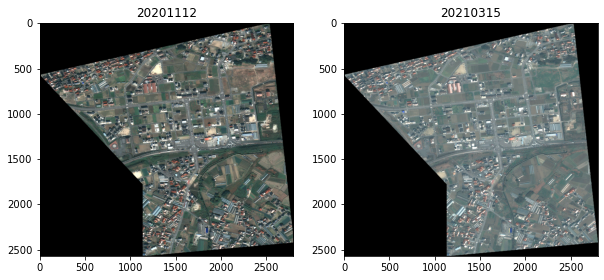

In [92]:
# Image check
import utils
def stack_3band(img, i=1, j=2, k=4, gray=False):
    '''
    False color visuliazation
    [1,2,4] - RGB
    [7,3,1] - cement
    '''
    img_3band = np.stack([img[:, :, i],
                         img[:, :, j],
                         img[:, :, k]], axis=2)
    img_gray = (img[:, :, i] + img[:, :, j] + img[:, :, k]) / 3
    if gray:
        return img_gray[:, :, np.newaxis].astype('int32')
    else:
        return img_3band

psh_rgb1 = stack_3band(psh1, 0,1,2)
psh_rgb2 = stack_3band(psh2, 0,1,2)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (10, 6))
ax1.imshow(utils.scale_percentile(psh_rgb1))
ax1.set_title('20201112')
ax2.set_title('20210315')
ax2.imshow(utils.scale_percentile(psh_rgb2))

In [ ]:
psh_rgb1.shape

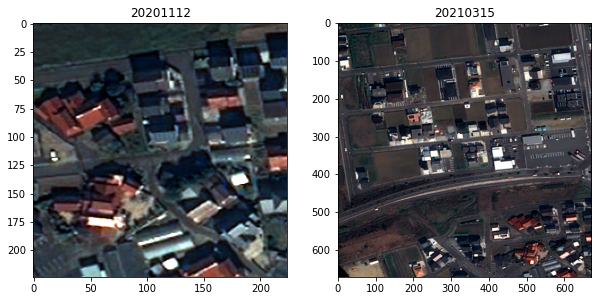

In [127]:
_psh_rgb1 = psh_rgb1[1000+224*2:1000+224*3, 1000+224*2:1000+224*3]
_psh_rgb2 = psh_rgb2[1000:1000+224*3, 1000:1000+224*3]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (10, 6))
ax1.imshow(utils.scale_percentile(_psh_rgb1))
ax1.set_title('20201112')
ax2.set_title('20210315')
ax2.imshow(utils.scale_percentile(_psh_rgb2))

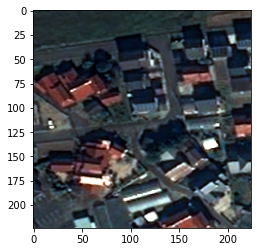

In [149]:
_psh1 = psh1[1000+224*2:1000+224*3, 1000+224*2:1000+224*3, :]
_psh1_rgb = _psh1[:,:,:3]
# _psh1 = psh1[1000:1000+448, 1000:1000+448, :]
# img = Image.fromarray(np.uint8(_psh1))
# _psh1 = np.asarray(img.resize((224,224)))

if _psh1_rgb.max() != 0:
    _psh1_rgb_norm = _psh1_rgb / _psh1_rgb.max()

plt.figure()
plt.imshow(utils.scale_percentile(_psh1_rgb_norm))

In [150]:
img_gray = rgb2gray(_psh1_rgb_norm) # HxW(there is no ch)
img_gray = img_gray[:,:,np.newaxis] # change to HxWxch

if img_gray.max() != 0:
    img_gray = img_gray / img_gray.max()

In [151]:
#_psh1 = np.array(_psh1)
_psh1_gray = rgb2gray(_psh1_rgb_norm)
_psh1_gray = _psh1_gray[:,:,np.newaxis]
if _psh1_gray.max() != 0:
    _psh1_gray_norm = _psh1_gray / _psh1_gray.max()
_psh1_gray_norm = _psh1_gray_norm.transpose(2,0,1)
_psh1_gray_norm = _psh1_gray_norm[np.newaxis,:,:,:]
_psh1_gray_norm.shape

(1, 1, 224, 224)

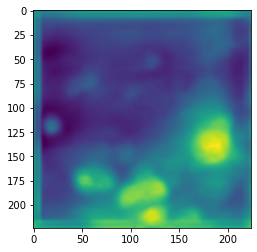

In [152]:
pred = loaded_model(torch.from_numpy(_psh1_gray_norm.astype(np.float32)).to(device))
pred = pred.cpu().detach().numpy().squeeze()
#pred = np.where(pred>=0.5, 1, 0)
plt.imshow(pred)